# Economic Data Analysis on USA States

## Download Packages

In [ ]:
!pip install plotly
!pip install fredapi
!pip install pandoc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


from fredapi import Fred

fred_key = '7cb157a9e3982332e03cfb7f148eaabc'



## Creating the Fred Object

In [7]:
fred = Fred(api_key=fred_key)

## Search for Economic Data: "Unemployement Rate Per State"

In [8]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
unemp_df

id realtime_start realtime_end  \
series id                                                        
UNRATE                      UNRATE     2024-02-01   2024-02-01   
LNS14000006            LNS14000006     2024-02-01   2024-02-01   
CAUR                          CAUR     2024-02-01   2024-02-01   
LNS14000024            LNS14000024     2024-02-01   2024-02-01   
M0892AUSM156SNBR  M0892AUSM156SNBR     2024-02-01   2024-02-01   
...                            ...            ...          ...   
M08320USM156SNBR  M08320USM156SNBR     2024-02-01   2024-02-01   
USAURAMS                  USAURAMS     2024-02-01   2024-02-01   
LNS14023569            LNS14023569     2024-02-01   2024-02-01   
LNS14000048            LNS14000048     2024-02-01   2024-02-01   
LNS14000015            LNS14000015     2024-02-01   2024-02-01   

                                                              title  \
series id                                                             
UNRATE                                            Unemployment Rate   
LNS14000006           Unemployment Rate - Black or African American   
CAUR                                Unemployment Rate in California   
LNS14000024                      Unemployment Rate - 20 Yrs. & over   
M0892AUSM156SNBR                Unemployment Rate for United States   
...                                                             ...   
M08320USM156SNBR  Unemployment Rate, Per Cent of Persons Unemplo...   
USAURAMS          Unemployment Rate in the United States (DISCON...   
LNS14023569                        Unemployment Rate - New Entrants   
LNS14000048                      Unemployment Rate - 25 Yrs. & over   
LNS14000015                   Unemployment Rate - 16-19 Yrs., White   

                 observation_start observation_end frequency frequency_short  \
series id                                                                      
UNRATE                  1948-01-01      2023-12-01   Monthly               M   
LNS14000006             1972-01-01      2023-12-01   Monthly               M   
CAUR                    1976-01-01      2023-12-01   Monthly               M   
LNS14000024             1948-01-01      2023-12-01   Monthly               M   
M0892AUSM156SNBR        1929-04-01      1942-06-01   Monthly               M   
...                            ...             ...       ...             ...   
M08320USM156SNBR        1948-01-01      1969-04-01   Monthly               M   
USAURAMS                2007-01-01      2013-06-01   Monthly               M   
LNS14023569             1967-01-01      2023-12-01   Monthly               M   
LNS14000048             1948-01-01      2023-12-01   Monthly               M   
LNS14000015             1954-01-01      2023-12-01   Monthly               M   

                    units units_short  seasonal_adjustment  \
series id                                                    
UNRATE            Percent           %  Seasonally Adjusted   
LNS14000006       Percent           %  Seasonally Adjusted   
CAUR              Percent           %  Seasonally Adjusted   
LNS14000024       Percent           %  Seasonally Adjusted   
M0892AUSM156SNBR  Percent           %  Seasonally Adjusted   
...                   ...         ...                  ...   
M08320USM156SNBR  Percent           %  Seasonally Adjusted   
USAURAMS          Percent           %  Seasonally Adjusted   
LNS14023569       Percent           %  Seasonally Adjusted   
LNS14000048       Percent           %  Seasonally Adjusted   
LNS14000015       Percent           %  Seasonally Adjusted   

                 seasonal_adjustment_short               last_updated  \
series id                                                               
UNRATE                                  SA  2024-01-12 10:28:02-06:00   
LNS14000006                             SA  2024-01-12 10:28:18-06:00   
CAUR                                    SA  2024-01-25 12:42:01-06:00   
LNS14000024                         

## Pull & Join Multiple Data Series

In [9]:
# List to store individual results for each ID
all_results = []

# Loop through each ID in the DataFrame
for myid in unemp_df.index:
    # Retrieve series data from FRED 
    results = fred.get_series(myid)
    
    # Convert the series to a DataFrame 
    results = results.to_frame(name=myid)
    
    # Append the DataFrame to the list of results
    all_results.append(results)
    
    # Introduce a delay to avoid overloading the API (adjust as needed)
    time.sleep(0.1)

# Concatenate all the individual DataFrames into a single DataFrame
uemp_results = pd.concat(all_results, axis=1)

In [10]:
# List to store column names to be dropped
cols_to_drop = []

# Iterate through each column in uemp_results DataFrame
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
        
# Drop columns from uemp_results based on the list of columns to be dropped
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)


In [11]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [12]:
# Plot States Unemployment Rate
un_states = uemp_states.query('index >= 2014 and index < 2024') 
fig = px.line(un_states, title = 'Unemployment Rate by State over a period of 10 years')

# Display the plot in notebook 
fig.show("notebook")         


## Pull January 2023 Unemployment Rate Per State

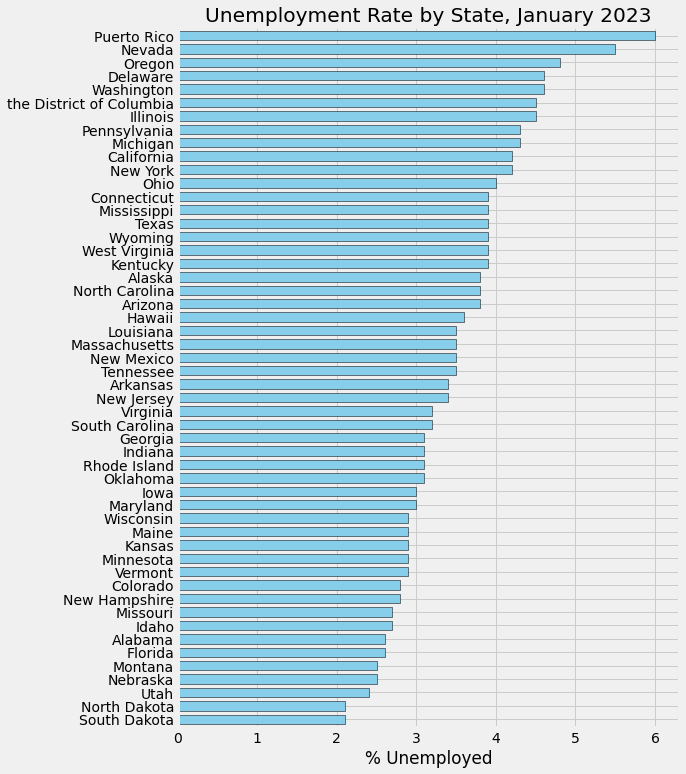

In [13]:
# Selecting and plotting the data for January 2023
ax = uemp_states.loc[uemp_states.index == '2023-01-01'].T \
    .sort_values('2023-01-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, January 2023', color='skyblue')  # Set color to sky blue

# Removing legend
ax.legend().remove()

# Setting x-axis label
ax.set_xlabel('% Unemployed')

# Displaying the plot
plt.show()

## Pull Participation Rate 

In [14]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [15]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) 
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## Plot Unemployment Rate VS Participation Rate (2023-2024)

In [16]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

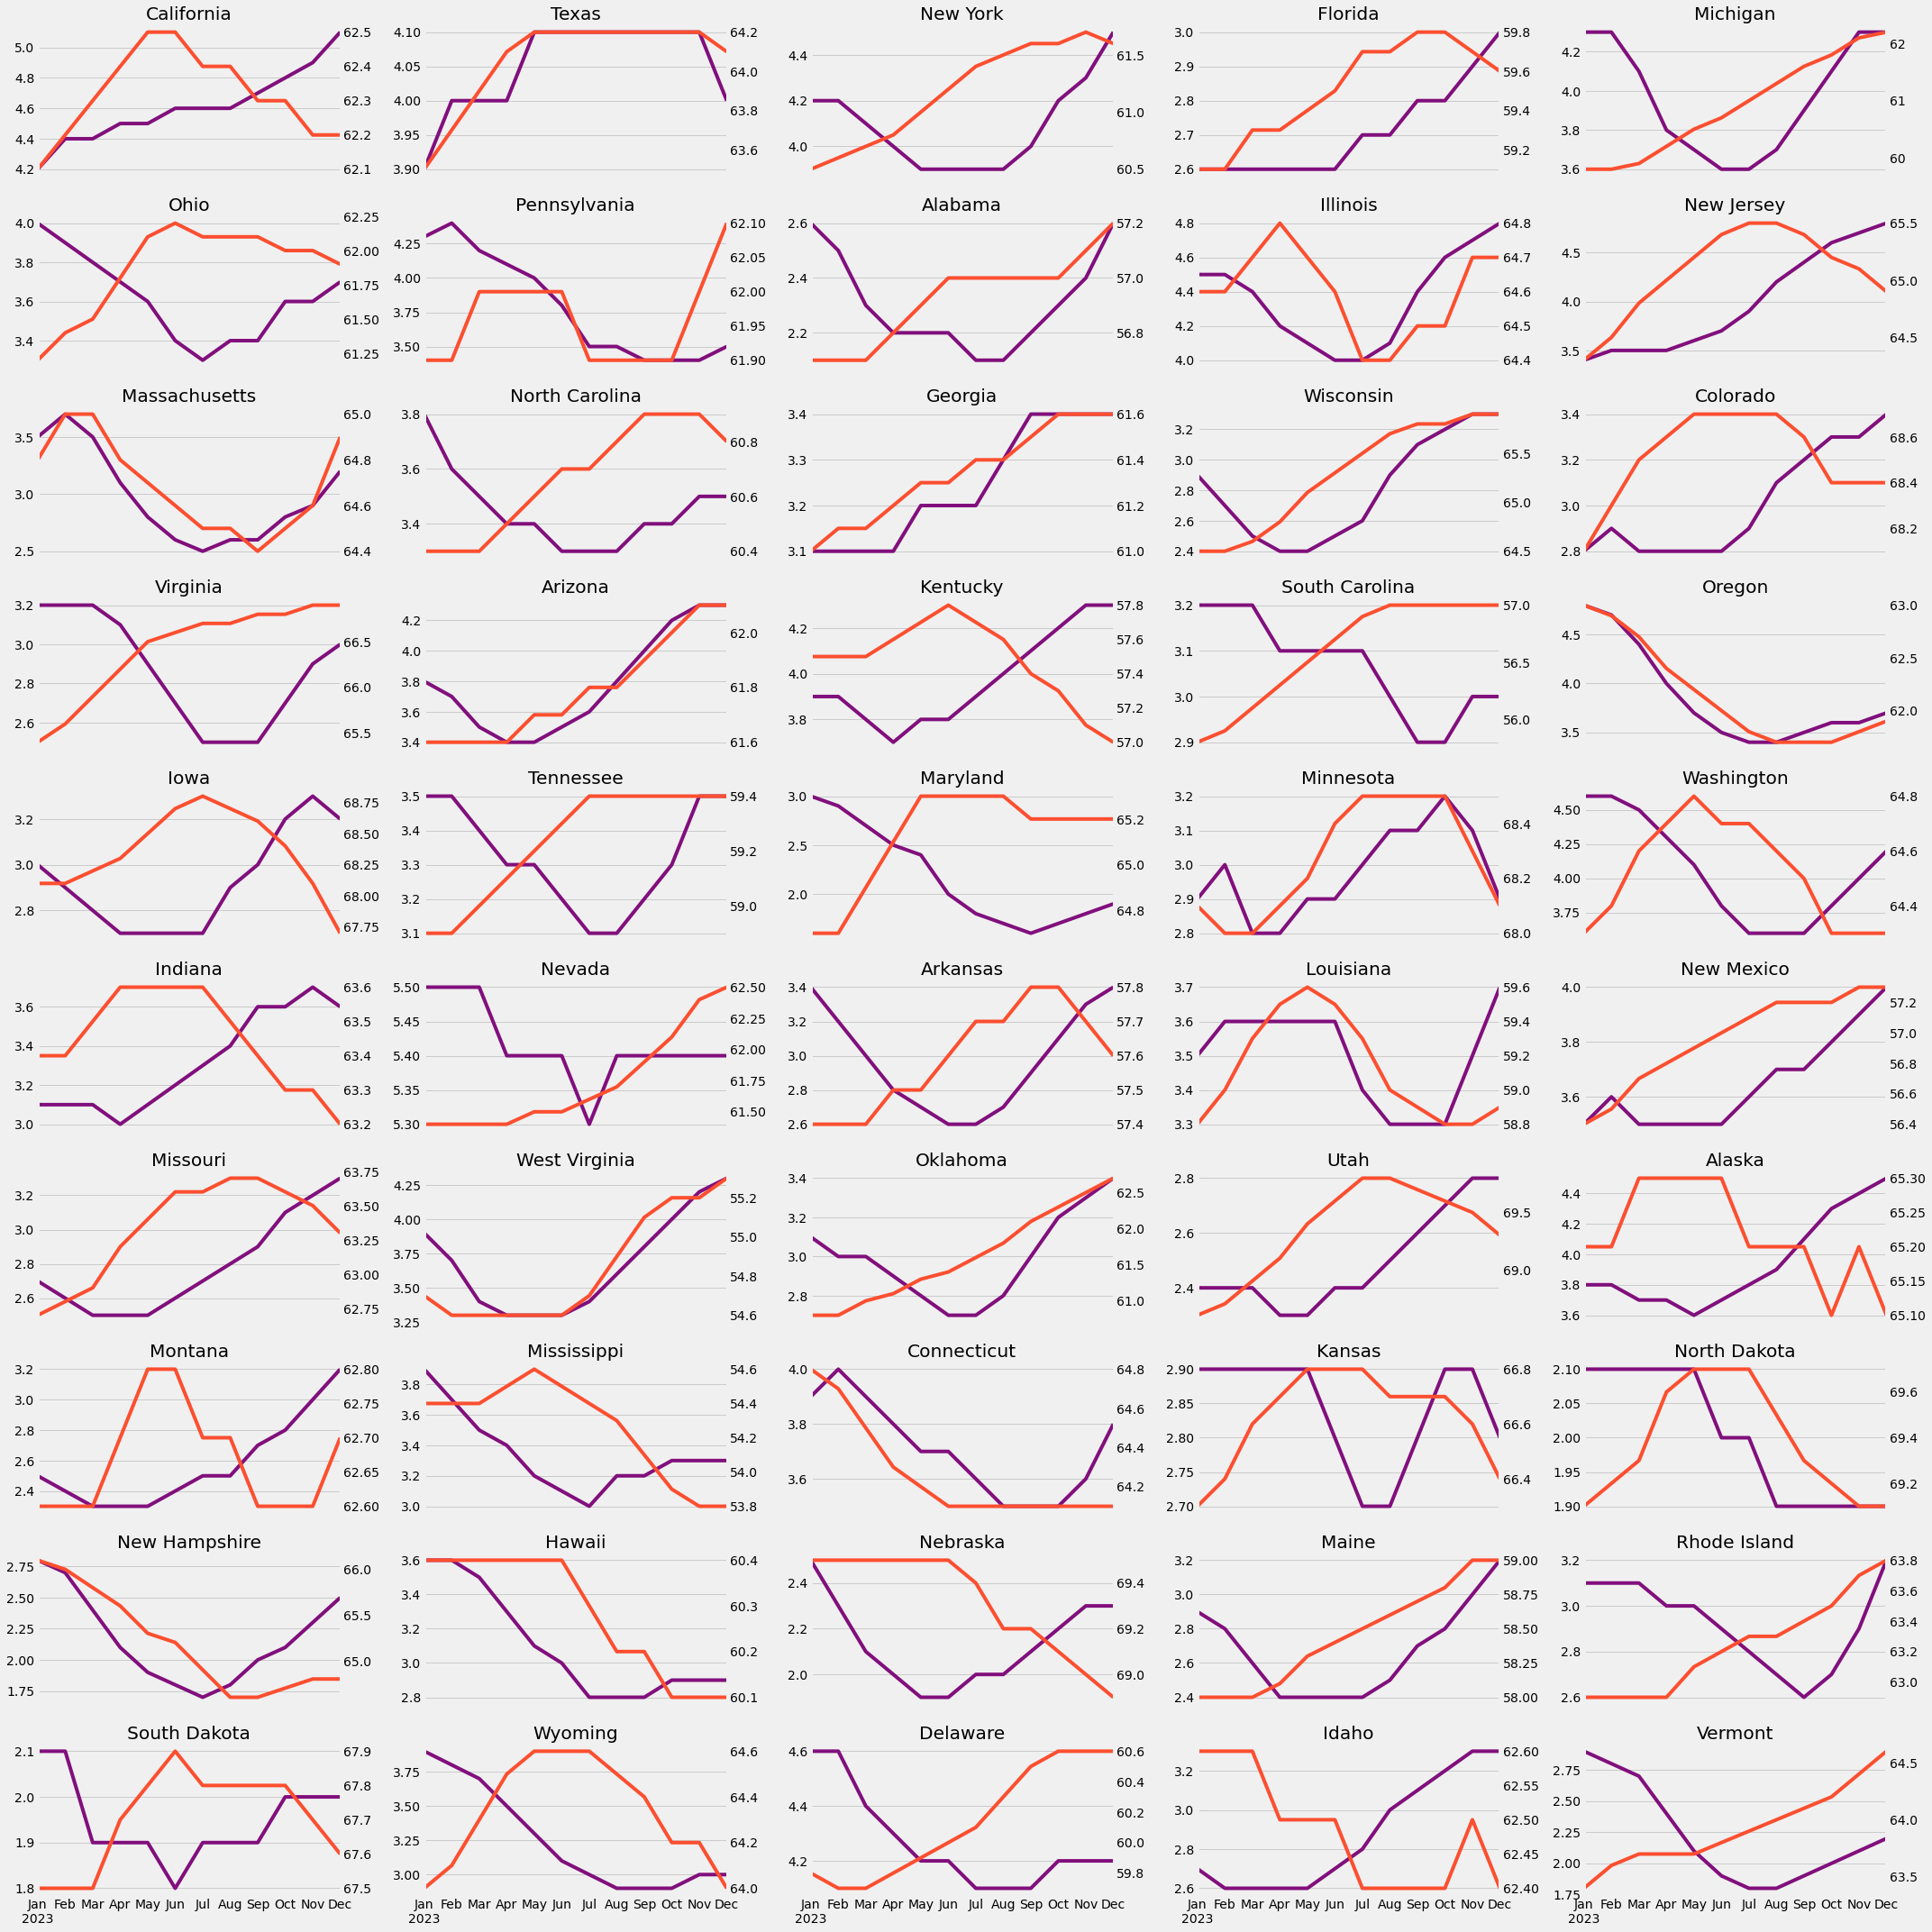

In [17]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2023 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment', color=color_pal[5])
    part_states.query('index >= 2023 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

## Example of New york

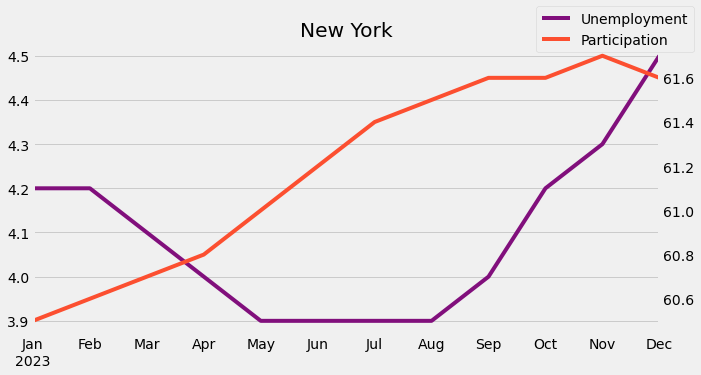

In [18]:
state = 'New York'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2023 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment', color=color_pal[5])
l2 = part_states.dropna().query('index >= 2023 and index < 2024')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()

# End 